In [3]:
import pandas as pd
from datetime import datetime
import numpy as np

In [4]:
#optional 2023 spcific run hashed out

df = pd.read_csv('../gateio_data/aggregated_trade_data.csv')
#df = pd.read_csv('./gateio_data/aggregated_trade_data_23season.csv')
token_lookup = pd.read_csv('../football_strat/fanTokens.csv')
#matches_old = pd.read_csv("./football_strat/matchdays - Sheet1.csv")
btc_rets = pd.read_csv("../gateio_data//btc_daily_rets.csv")
#btc_rets = pd.read_csv("./gateio_data/btc_daily_rets_23season.csv")
matches = pd.read_csv("../football_strat/matchdays_new.csv")
#matches = pd.read_csv("./football_strat/matchdays_2023season.csv")

In [5]:

#getting 'Club'/name variable into matches df
matches['Club'] = matches['tickers'].map(token_lookup[['ticker','Name']].set_index('ticker').to_dict()['Name'])

In [6]:
df = df.sort_values(['ticker', 'timestamp'])

In [7]:
token_lookup['ticker'] = [str(i)+"_USDT"  for i in token_lookup['ticker']]

In [8]:
matches['Date'] = matches['matchdays']

In [9]:
matches = matches[[len(i)>1 for i in matches['Date']]]
splits = [i.split(" ") for i in matches['Date']]
months = [datetime.strptime(i[1], '%b').month for i in splits]
days = [i[2].split(",")[0] for i in splits]
years = [i[3].split(",")[0] for i in splits]
matches['Day'] = days
matches['Month'] = months
matches['Year'] = years

In [10]:
matches['DateTime'] = matches['Day'].astype(str)+"/"+matches['Month'].astype(str)+"/"+matches['Year'].astype(str)
matches['DateTime'] = pd.to_datetime(matches['DateTime'], format= "%d/%m/%Y")
matches['MatchDay'] = 1

In [11]:
matches = matches.set_index('Club').join(token_lookup.set_index('Name'))

In [12]:
btc_rets['timestamp'] = pd.to_datetime(btc_rets['timestamp'])
btc_rets.set_index('timestamp',inplace=True)
btc_rets.rename(columns={'vwap':'btc'}, inplace=True)
btc_rets['btc'] = btc_rets['btc'].rolling(2).sum()

In [13]:
pd.options.mode.chained_assignment = None  # default='warn'

agg_df = pd.DataFrame()
for each_club in df['ticker'].drop_duplicates():
    
    #filter to one club to avoid pct_change between clubs
    club_df = df.loc[df['ticker'] == each_club]
    club_df['timestamp'] = pd.to_datetime(club_df['timestamp'])
    club_df.set_index('timestamp', inplace=True)
    club_df = club_df['vwap'].pct_change().resample('d').sum()
    returns = pd.DataFrame(club_df.rolling(2).sum())
    returns['ticker'] = each_club

    #reset index so merge sets it
    returns.reset_index(inplace=True)
    merge_df = pd.merge(returns, matches,  how='left', left_on=['timestamp','ticker'], right_on = ['DateTime','ticker'])
    merge_df = merge_df.dropna(axis=0)
    merge_df = merge_df[['timestamp','vwap','ticker']]
    
    merge_df.set_index('timestamp', inplace=True)
    merge_df.drop_duplicates(inplace=True)
    
    merge_df = pd.concat([merge_df, btc_rets], axis=1)
    
    agg_df = pd.concat([agg_df, merge_df], axis=0)


In [14]:
#- becuase strategy returns are BTC/asset spread trade
agg_df['strat_rets'] = agg_df['btc']-agg_df['vwap']

In [15]:
agg_df.dropna(inplace=True)

In [16]:
agg_df.sort_index(inplace=True)

<AxesSubplot:title={'center':'Performance of strategy'}, xlabel='timestamp'>

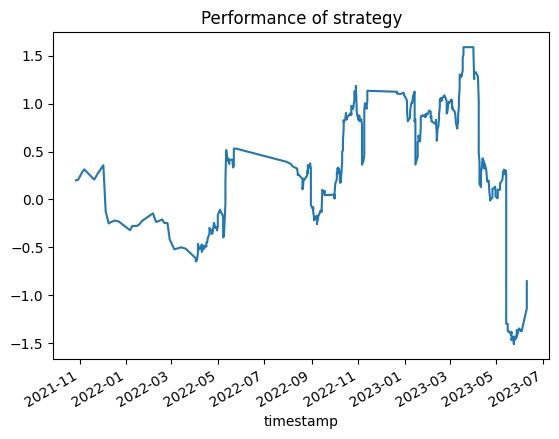

In [17]:
agg_df['strat_rets'].cumsum().plot(title="Performance of strategy")

<AxesSubplot:title={'center':'Performance of strategy'}, xlabel='timestamp'>

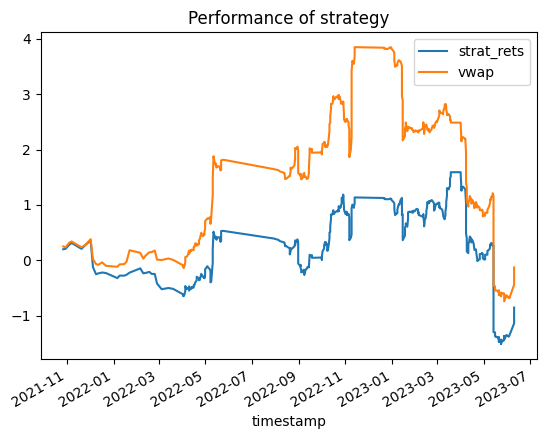

In [18]:
agg_df['strat_rets'].cumsum().plot(legend=True)
(-agg_df['vwap']).cumsum().plot(legend=True, title="Performance of strategy")

In [90]:
#number of spread trades
agg_df['strat_rets'].count()

442

In [92]:
#sharpe ratio of strategy, not including risk free rate or trading fees
(agg_df['strat_rets'].mean()*252)/(np.sqrt(252)*agg_df['strat_rets'].std())

-0.2997701216303708